In [7]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

In [2]:
##1. Open the grid file of ECCO
grid_dir  = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/')
ds_grid   = xr.open_dataset(grid_dir / 'GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')
# Open the windstress data of ECCO from 1992-2019
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS')
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))
TAU_X     = [[] for _ in range(12)];TAU_Y = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##This loops throughout the 336 monthly files from 1992-2019
    #print("I am in file",i)
    ds           = xr.open_dataset(file_path)
    month_idx    = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    tau_x        = ds.oceTAUX
    tau_y        = ds.oceTAUY
    # rotate tau_x and tau_y to e-w and n-s components
    tau_e, tau_n = ecco.vector_calc.UEVNfromUXVY(tau_x, tau_y, ds_grid)
    TAU_X[month_idx].append(tau_e)
    TAU_Y[month_idx].append(tau_n)
##------------------- 2. Create the windstress climatology for each windstress component --------------------------------------------
clim_TAU_X = [None]*12;clim_TAU_Y = [None]*12
for m in range(12):
    da_x          = xr.concat(TAU_X[m], dim='time')
    da_y          = xr.concat(TAU_Y[m], dim='time')
    clim_TAU_X[m] = da_x.mean(dim='time')
    clim_TAU_Y[m] = da_y.mean(dim='time')
##---------------------- 3. Create the windstress anomalies ----------------------------------------
montitles  = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
ANOM_TAU_X = [[] for _ in range(12)];ANOM_TAU_Y = [[] for _ in range(12)]
for m in range(12):# loop over months
 for y in range(0,28): # loop over the years
        anomx = TAU_X[m][y] - clim_TAU_X[m]
        ANOM_TAU_X[m].append(anomx) ##there will be ANOM_TAU_X and each of them will have 28 years inside
        anomy = TAU_Y[m][y] - clim_TAU_Y[m]
        ANOM_TAU_Y[m].append(anomy)


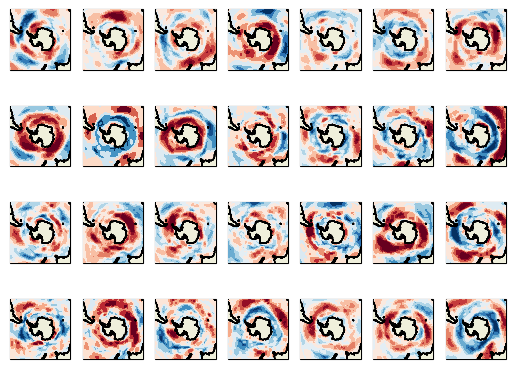

In [10]:
##2. Plot the monthly windstress files for every year
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
nrow      = 4;ncol=7
cmin      = -0.1;cmax =0.1;years= np.arange(1992,2020,1)
colorm    = cmocean.cm.balance
for m in range(12):# loop over months
 for a in range(0,28):
    var = ANOM_TAU_X[m][a][0,:,:,:] ##january/first year/have to mhednizo the xrono
    ecco.plot_proj_to_latlon_grid(ds_grid.XC, ds_grid.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=False,dx=1, dy=1,lat_lim=-40,cmin=cmin,cmax=cmax,colormap=colorm,show_coastline=True,subplot_grid=[nrow, ncol, a+1]);
 plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/WINDSTRESS/TAUX_ANOM_{montitles[m]}_2D.png')


In [11]:
#3. Plot the zonal windstress anomaly for a given month of a year:
colorm = cmocean.cm.balance
cmin   = -0.1;cmax =0.1
var    = ANOM_TAU_X[1][-3][0,:,:,:] ##january/first year/have to mhednizo the xrono
fig    = ecco.plot_proj_to_latlon_grid(ds_grid.XC, ds_grid.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=True,dx=1, dy=1,lat_lim=-40,cmin=cmin,cmax=cmax,colormap=colorm,show_coastline=True);
fig[0].suptitle('Feb 2017 Windstress x anomaly')
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/WINDSTRESS/TAUX_ANOM_FEB_2017_2D.png',dpi=200)

## Plot the meridional windstress anomaly for a given month and year
colorm = cmocean.cm.balance
cmin   = -0.1;cmax =0.1
var    = ANOM_TAU_Y[1][-3][0,:,:,:] ##january/first year/have to mhednizo the xrono
fig    = ecco.plot_proj_to_latlon_grid(ds_grid.XC, ds_grid.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=True,dx=1, dy=1,lat_lim=-40,cmin=cmin,cmax=cmax,colormap=colorm,show_coastline=True);
fig[0].suptitle('Feb 2017 Windstress y anomaly')
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/WINDSTRESS/TAUY_ANOM_FEB_2017_2D.png',dpi=200)

In [3]:
#4. Create the spatially-averaged Windstress timeseries from 1992-2019 for a given tile
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS')# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))
TMSRTAU_X = [];TMSRTAU_Y = []
tile      = 9
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##This loops throughout the 336 monthly files from 1992-2019
    ds       = xr.open_dataset(file_path);t0 = ds.time.values[0] # Extract the time stamp for this file
    tau_x    = ds.oceTAUX
    tau_y    = ds.oceTAUY
    tau_e, tau_n = ecco.vector_calc.UEVNfromUXVY(tau_x, tau_y, ds_grid)
    taux_fin = tau_e[0,tile,:,:].mean(dim=["j","i"],skipna=True)
    tauy_fin = tau_n[0,tile,:,:].mean(dim=["j","i"],skipna=True)
    TMSRTAU_X.append(taux_fin)
    TMSRTAU_Y.append(tauy_fin)
ts_x = xr.concat(TMSRTAU_X, dim='time').sortby('time')
ts_y = xr.concat(TMSRTAU_Y, dim='time').sortby('time')


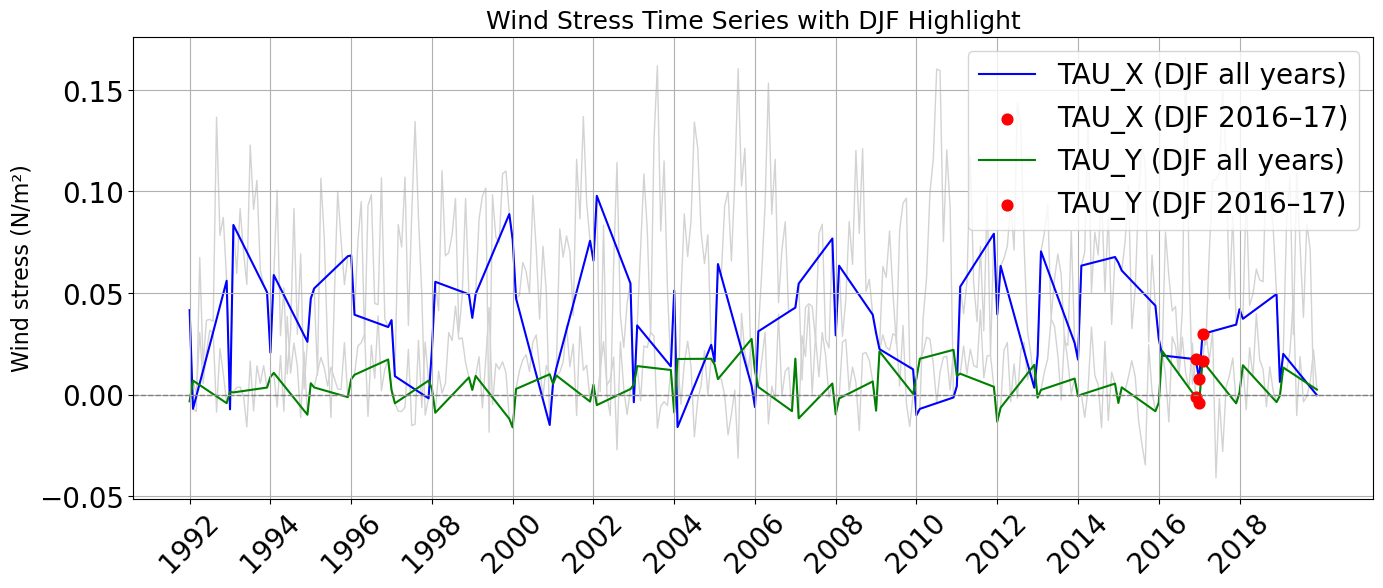

In [9]:
#5. Plot the (absolute) Zonal and Meridional windstress timeseries and highlight the DJF windstress every year and the year 2016-2017 interested in
ystart, yfin = 1992, 2020
nmonths      = (yfin - ystart) * 12      # 1992–2019
dates        = pd.date_range(start=f'{ystart}-01-01',periods=nmonths,freq='MS')
# your two series, length = nmonths,ts_x = …; ts_y = …  
varias       = [ts_x, ts_y]
labels       = ['TAU_X', 'TAU_Y']
colors       = ['blue', 'green']   # <-- now ts_y will be green

# --- identify DJF months and the single winter of interest ---
djf_mask     = (dates.month == 12) | (dates.month <= 2)
djf_idx      = np.where(djf_mask)[0]

# winter 2016–17 → Dec ’16, Jan ’17, Feb ’17
dot_mask = ((dates.year == 2016) & (dates.month == 12)) | \
           ((dates.year == 2017) & (dates.month.isin([1,2])))
dot_idx  = np.where(dot_mask)[0]

# --- plot ---
fig, ax  = plt.subplots(figsize=(16, 6))
for series, lbl, col in zip(varias, labels, colors):
    # full series in light grey
    ax.plot(np.arange(nmonths), series,
            color='lightgray', linewidth=1, zorder=0)
    # DJF overlay in blue for TAU_X, green for TAU_Y
    ax.plot(djf_idx, series[djf_idx],
            color=col, linewidth=1.5, zorder=1,
            label=f'{lbl} (DJF all years)')
    # red dots for winter 2016–17
    ax.scatter(dot_idx, series[dot_idx],
               color='red', s=60, zorder=2,
               label=f'{lbl} (DJF 2016–17)')

# formatting
year_ticks  = list(range(0, nmonths, 12))
year_labels = [str(y) for y in range(ystart, yfin)]
ax.set_xticks(year_ticks[::2])
ax.set_xticklabels(year_labels[::2], rotation=45, fontsize=14)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel('Wind stress (N/m²)', fontsize=16)
ax.set_title('Wind Stress Time Series with DJF Highlight', fontsize=18)
ax.grid(True)
ax.legend(fontsize=20)
ax.tick_params(axis='both', labelsize=20)

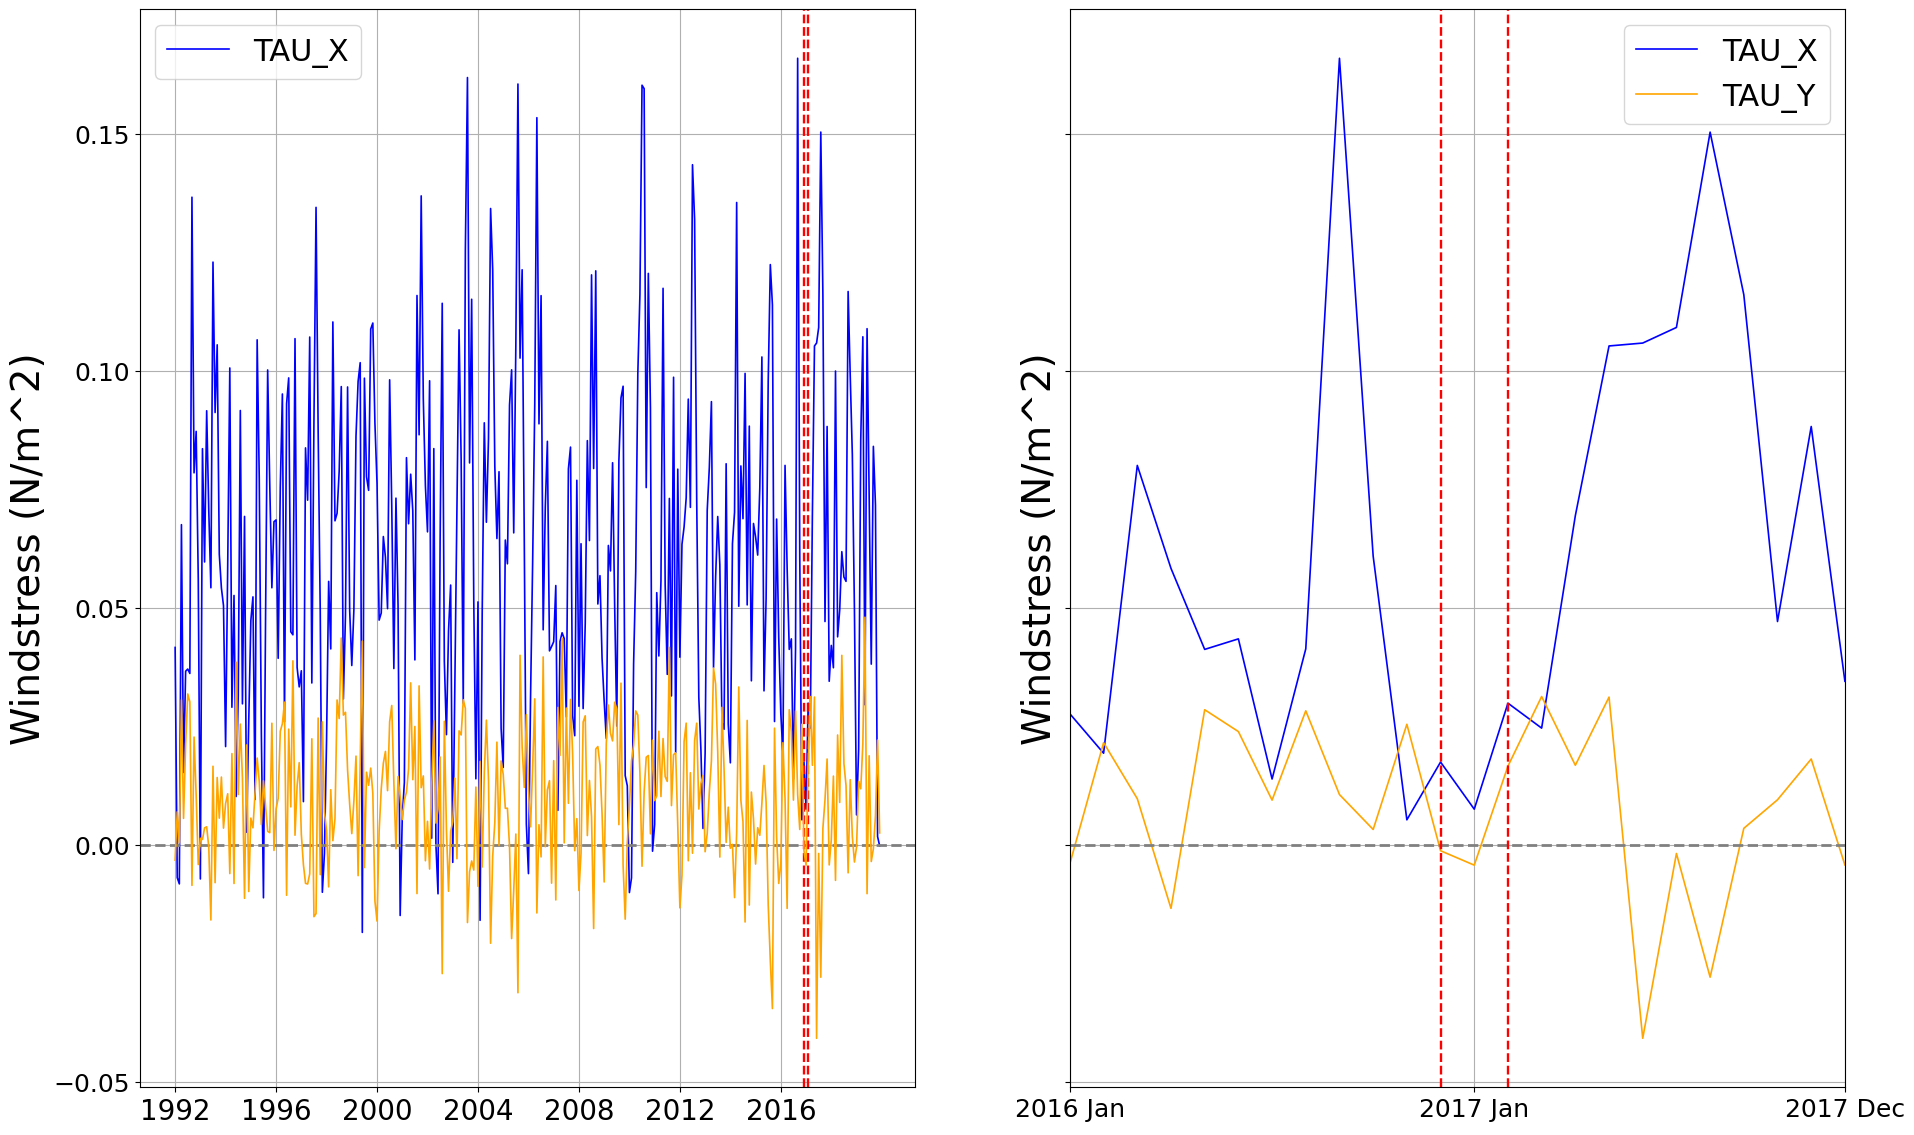

In [12]:
#6. Plot the (absolute) zonal & meridional windstress along with a zoom on the time of the MHW (for a given tile)
varias      = [ts_x,ts_y]
labels      = ['TAU_X', 'TAU_Y']
colors      = ['blue','orange']
year_labels = [str(year) for year in range(1992, 2020)]
year_ticks  = list(range(0, 336, 12))  # one tick every 12 months
# compute zoom window indices
start_2016  = (2016 - 1992) * 12        # = 24*12 = 288  → Jan 2016
end_2017    = (2017 - 1992) * 12 + 11   # = 25*12+11 = 311 → Dec 2017
zoom_idx    = list(range(start_2016, end_2017 + 1))  # 288…311
nrow        = 1;ncol=2
fig, axs    = plt.subplots(nrow,ncol,figsize=(22,14),sharey=True);axis= fig.axes
for i in range(len(varias)):
    ### 1st plot ##
    axis[0].plot(range(336), varias[i], label=labels[i], color=colors[i], linewidth=1.2)
    axis[0].set_xticks(year_ticks[::4])
    axis[0].set_xticklabels(year_labels[::4], fontsize=20)
    ### 2nd plto 
    axis[1].plot(zoom_idx, varias[i][start_2016:end_2017+1],label=labels[i], color=colors[i],  linewidth=1.2)
    axis[1].set_xlim(start_2016, end_2017)# label only 2016 & 2017 on this zoom
    axis[1].set_xticks([start_2016, (2017-1992)*12, end_2017])
    axis[1].set_xticklabels(['2016 Jan', '2017 Jan', '2017 Dec'], fontsize=20)
    axis[i].axhline(0, color='gray', linewidth=2, linestyle='--')
    axis[i].tick_params(axis='both', labelsize=18)
    axis[i].set_ylabel('Windstress (N/m^2)', fontsize=28)
    axis[i].legend(loc="best",fontsize=22)
    axis[i].grid(True)
    axis[i].axvline(x=299, color='red', linestyle='--', linewidth=1.7, label='Dec 2016')
    axis[i].axvline(x=301, color='red', linestyle='--', linewidth=1.7, label='Feb 2017')
#plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/WINDSTRESS/WINDSTRESS_TILE{tile}_2D.png')

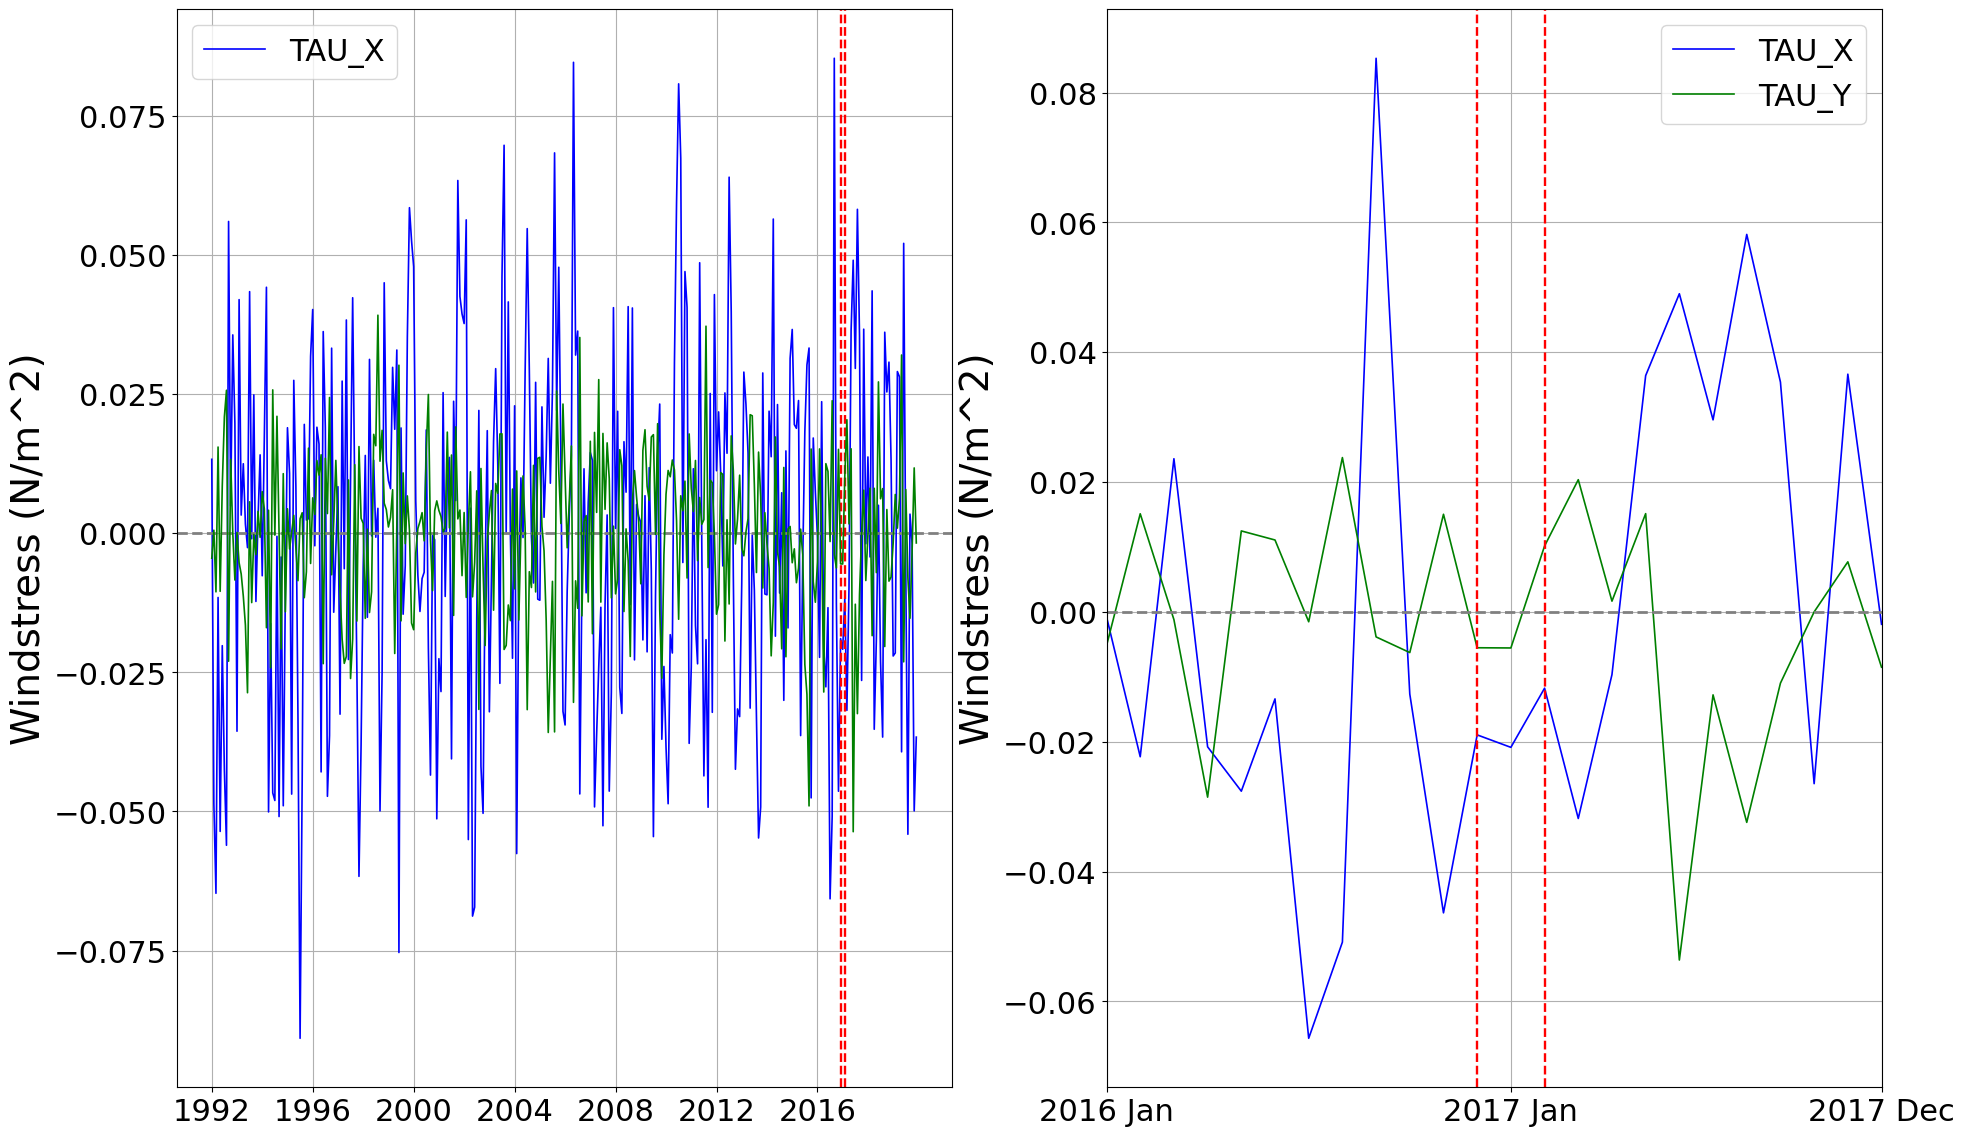

In [10]:
#5. Plot the zonal and meridional windstress anomalous timeseries & their zoom over 2016-2017
labels      = ['TAU_X', 'TAU_Y']
colors      = ['blue','green']
year_labels = [str(year) for year in range(1992, 2020)]
year_ticks  = list(range(0, 336, 12))  # one tick every 12 months
# compute zoom window indices
start_2016  = (2016 - 1992) * 12        # = 24*12 = 288  → Jan 2016
end_2017    = (2017 - 1992) * 12 + 11   # = 25*12+11 = 311 → Dec 2017
zoom_idx    = list(range(start_2016, end_2017 + 1))  # 288…311
nrow        = 1;ncol=2

dates       = pd.date_range(start='1992-01-01', periods=336, freq='MS')
variables   = [ts_x,ts_y]
nrow        = 1;ncol=2
fig, axs    = plt.subplots(nrow,ncol,figsize=(22,14),sharey=False);axis= fig.axes
for i in range(0,2):
  # 2. Convert your DataArray to a Series with that index:
  ts_pd        = pd.Series(variables[i].values, index=dates, name='ts_x')
  monthly_clim = ts_pd.groupby(ts_pd.index.month).mean()# 3. Now group by calendar month and compute the climatology:
# 4. Tile the 12-month climatology to full length:
  n_months     = len(ts_pd)         # 336
  n_repeats    = n_months // 12     # 28
  clim_full    = np.tile(monthly_clim.values, n_repeats)
  # 5. Re-wrap into a Series aligned with your dates:
  clim_full_series = pd.Series(clim_full, index=ts_pd.index, name='Climatology')
# 6. Subtract to get anomalies in windstress timeseries
  anomalies     = ts_pd - clim_full_series
  ### 1st plot: Windstress anomalies timeseries 1992-2019
  axis[0].plot(range(336), anomalies, label=labels[i], color=colors[i], linewidth=1.2)
  axis[0].set_xticks(year_ticks[::4])
  axis[0].set_xticklabels(year_labels[::4], fontsize=22)
  ### 2nd plot 
  axis[1].plot(zoom_idx, anomalies[start_2016:end_2017+1],label=labels[i], color=colors[i],  linewidth=1.2)
  axis[1].set_xlim(start_2016, end_2017)# label only 2016 & 2017 on this zoom
  axis[1].set_xticks([start_2016, (2017-1992)*12, end_2017])
  axis[1].set_xticklabels(['2016 Jan', '2017 Jan', '2017 Dec'], fontsize=20)
  axis[i].axhline(0, color='gray', linewidth=2, linestyle='--')
  axis[i].tick_params(axis='both', labelsize=22)
  axis[i].set_ylabel('Windstress (N/m^2)', fontsize=28)
  axis[i].legend(loc="best",fontsize=22)
  axis[i].grid(True)
  axis[i].axvline(x=299, color='red', linestyle='--', linewidth=1.7, label='Dec 2016')
  axis[i].axvline(x=301, color='red', linestyle='--', linewidth=1.7, label='Feb 2017')
#plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/WINDSTRESS/WINDSTRESS_ANOM_TILE{tile}_2D.png')